In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.special import lambertw
from scipy.interpolate import UnivariateSpline
from multiprocessing import Pool
import seaborn as sns
import pandas as pd
import pickle
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
def ConstructHists(E_reco,Nbins=50):
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/0.1GeV.root


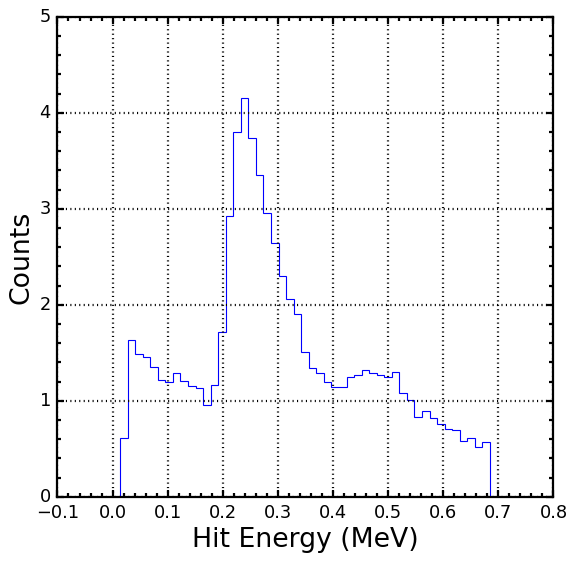

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/0.25GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/1.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/2.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/5.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/10.0GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_l

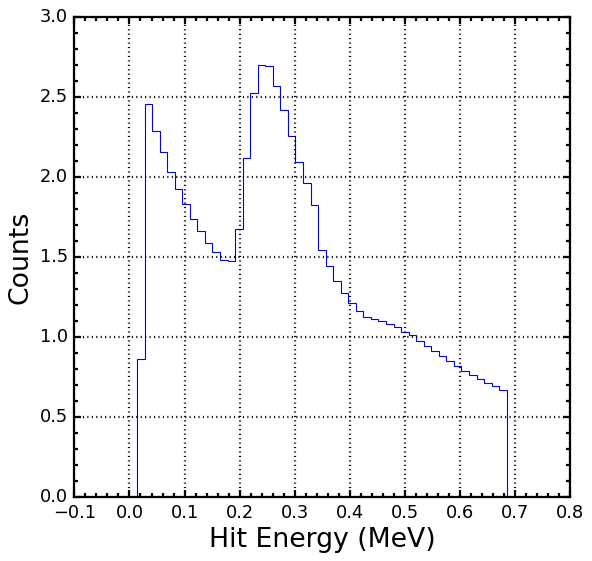

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_19.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_55.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_64.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_37.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_73.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Uniform/0_70GeV_82.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/

In [2]:
# 打开 ROOT 文件，载入 events tree
MIP_table={# Si thickness (mm) : MIP (MeV)
    0.15:0.0410,
    0.3:0.0861,
    0.45:0.1328,
    0.6:0.1803,
    0.75:0.2282
}
Threshold_i=0.1
Si=0.75  #mm
CellSize=5.0  #mm
SamplingLayer=40
ECAL_layers=80
CONF="CONF3"
Threshold=Threshold_i*MIP_table[Si]
def ReadData_Energy(DataPath, ParticleEnergy, precision=0.01):
    SumE_all = np.empty((0,))
    NHit_all = np.empty((0,))
    E_truth_all = np.empty((0,))
    NRootFiles = 0
    for i_E, E in enumerate(ParticleEnergy):
        NRootFiles += 1
        input_file_name = f"{DataPath}/{E}GeV.root"

        SumE, NHit, E_truth = ReadRoot(
            input_file_name,
            draw_hist=(NRootFiles == 1)
        )
        SumE_all = np.concatenate((SumE_all, SumE))
        NHit_all = np.concatenate((NHit_all, NHit))
        E_truth_all = np.concatenate((E_truth_all, E_truth))
    E_truth_all = np.round(E_truth_all / precision) * precision
    return SumE_all, NHit_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [
        os.path.join(DataPath, f)
        for f in os.listdir(DataPath)
        if f.endswith(".root")
    ]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    SumE_all = np.empty((0,))
    NHit_all = np.empty((0,))
    E_truth_all = np.empty((0,))
    for i, input_file in enumerate(root_files):
        SumE, NHit, E_truth = ReadRoot(
            input_file,
            draw_hist=(i == 0)  # 只有第一个画直方图
        )
        SumE_all = np.concatenate((SumE_all, SumE))
        NHit_all = np.concatenate((NHit_all, NHit))
        E_truth_all = np.concatenate((E_truth_all, E_truth))
    return SumE_all, NHit_all, E_truth_all
# def ReadRoot(input_file_name,draw_hist=False):
#     print(f"Processing file: {input_file_name}")
#     input_file = uproot.open(input_file_name)
#     tree = input_file["events"]
#     cellID = tree["simplecaloRO.cellID"].array(library="ak")
#     energy = tree["simplecaloRO.energy"].array(library="ak")
#     pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
#     pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
#     pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
#     E_truth = tree["MCParticles.p0"].array(library="ak")
#     threshold_mask = energy * 1000 > Threshold
#     cellID = cellID[threshold_mask]
#     energy = energy[threshold_mask]
#     pos_x = pos_x[threshold_mask]
#     pos_y = pos_y[threshold_mask]
#     pos_z = pos_z[threshold_mask]
#     calo_layer = cellID & 0x7F
#     num_events = len(energy)
#     if draw_hist:
#         print("threshold:", Threshold)
#         plt.hist(ak.to_numpy(ak.flatten(energy))*1000,
#             bins=50, range=(0, 3*MIP_table[Si]), histtype='step', density=True)
#         plt.xlabel('Hit Energy (MeV)')
#         plt.ylabel('Counts')
#         plt.show()
#     SumE = ak.to_numpy(ak.sum(energy, axis=1))            # float array
#     NHit = ak.to_numpy(ak.num(energy, axis=1))            # int array
#     # flatten truth
#     E_truth_flat = ak.to_numpy(ak.flatten(E_truth))
#     return SumE,NHit,E_truth_flat
def process_event_chunk(energy_chunk):
    SumE_chunk = np.array([e.sum() for e in energy_chunk])
    NHit_chunk = np.array([len(e) for e in energy_chunk])
    return SumE_chunk, NHit_chunk
def ReadRoot(input_file_name, draw_hist=False, num_cores=4):
    print(f"Processing file: {input_file_name}")
    with uproot.open(input_file_name) as input_file:
        tree = input_file["events"]
        energy = tree["simplecaloRO.energy"].array(library="np")  # numpy object array
        E_truth = tree["MCParticles.p0"].array(library="np")       # numpy object array
    mask = [e*1000 > Threshold for e in energy]
    energy = [e[m] for e, m in zip(energy, mask)]
    if draw_hist:
        plt.hist(np.concatenate(energy)*1000, bins=50, range=(0, 3*MIP_table[Si]), histtype='step', density=True)
        plt.xlabel('Hit Energy (MeV)')
        plt.ylabel('Counts')
        plt.show()
    num_events = len(energy)
    events_per_core = (num_events + num_cores - 1) // num_cores  # 向上取整
    chunks = [energy[i*events_per_core : (i+1)*events_per_core] for i in range(num_cores)]
    SumE_list = []
    NHit_list = []
    with Pool(num_cores) as pool:
        results = pool.map(process_event_chunk, chunks)    
    for s_chunk, n_chunk in results:
        SumE_list.append(s_chunk)
        NHit_list.append(n_chunk)
    SumE = np.concatenate(SumE_list)
    NHit = np.concatenate(NHit_list)
    E_truth_flat = np.concatenate(E_truth)    
    return SumE, NHit, E_truth_flat


#Read Data
DataPath_Validate=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/{CONF}/gamma/Validate/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}"
DataPath_Uniform=f"/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/{CONF}/gamma/Train/Merged_X{CellSize:.1f}mm_Y{CellSize:.1f}mm_Si{Si:.2f}mm_layer{SamplingLayer}_in{ECAL_layers}/Uniform"
Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
#Energy_test=(0.1,0.25,0.5,1.0,2.0,5.0,10.0)#For CONF4
E_test, N_test, E_truth_test = ReadData_Energy(DataPath_Validate,Energy_test)
E_uniform, N_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

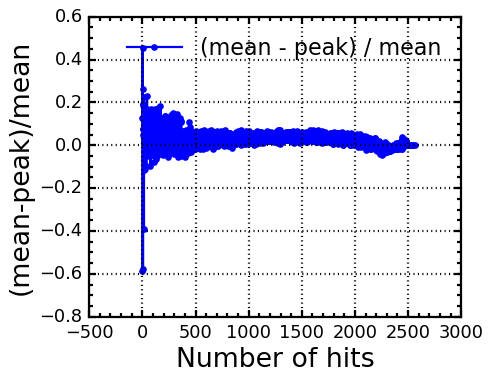

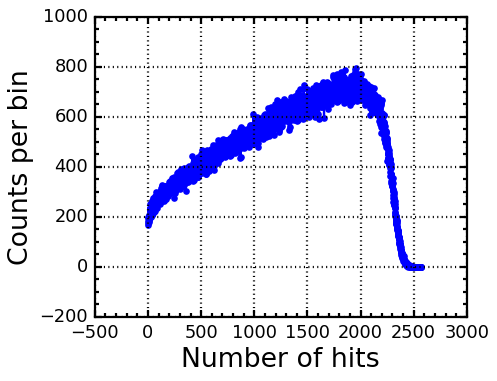

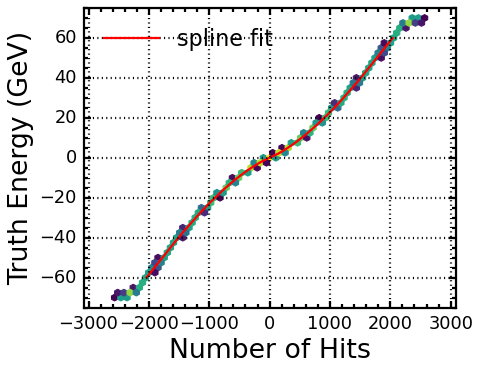

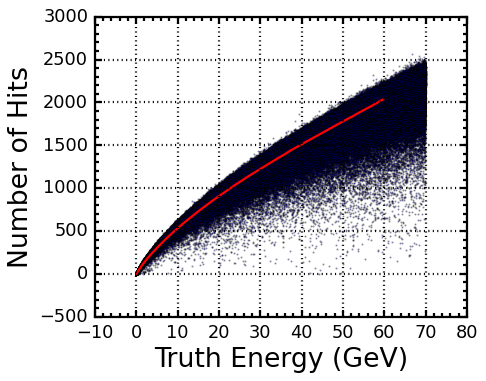

-0.00010308232384658583


In [19]:
def plot_NHit_vs_Etruth_spline(N, E_truth,s_factor=0):

    N = np.array(N).flatten()
    E_truth = np.array(E_truth).flatten()

    # sort
    sort_idx = np.argsort(N)
    N_sorted = N[sort_idx]
    E_sorted = E_truth[sort_idx]

    bin_edges = np.arange(-0.5, N_sorted.max() + 1.5, 1)
    bin_centers = np.arange(0, N_sorted.max() + 1, 1)

    E_bin_mean = np.array([
        E_sorted[(N_sorted >= bin_edges[i]) & (N_sorted < bin_edges[i+1])].mean()
        if np.any((N_sorted >= bin_edges[i]) & (N_sorted < bin_edges[i+1])) else np.nan
        for i in range(len(bin_centers))
    ])

    E_bin_peak = []
    N_bin=[]
    for i in range(len(bin_centers)):
        mask = (N_sorted >= bin_edges[i]) & (N_sorted < bin_edges[i+1])
        values = E_sorted[mask]
        N_bin.append(len(values))
        if len(values) == 0:
            E_bin_peak.append(np.nan)
            continue
    # histogram-based peak
        hist, edges = np.histogram(values, bins=50)
        peak_idx = np.argmax(hist)
        peak_center = 0.5 * (edges[peak_idx] + edges[peak_idx+1])
        E_bin_peak.append(peak_center)
    E_bin_peak = np.array(E_bin_peak)
    N_bin = np.array(N_bin)

    E_bin=E_bin_mean  # 可选择 mean 或 peak 作为拟合点
    relative = (E_bin_mean - E_bin_peak) / E_bin_mean
    plt.figure(figsize=(6,5))
    plt.plot(bin_centers, relative, 'o-', label="(mean - peak) / mean")
    plt.xlabel("Number of hits")
    plt.ylabel("(mean-peak)/mean")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(bin_centers, N_bin, 'o-')
    plt.xlabel("Number of hits")
    plt.ylabel("Counts per bin")
    plt.grid(True)
    plt.show()

    valid = ~np.isnan(E_bin)
    x_fit = bin_centers[valid]
    y_fit = E_bin[valid]
    x_sym = -x_fit
    y_sym = -y_fit
    x_full = np.concatenate((x_sym,[0],x_fit))
    y_full = np.concatenate((y_sym,[0],y_fit))
    sort_idx = np.argsort(x_full)
    x_full = x_full[sort_idx]
    y_full = y_full[sort_idx]

    # spline 拟合
    spline = UnivariateSpline(x_full, y_full, s=s_factor, k=5)

    # 绘图
    N_fine = np.linspace(x_full.min(), x_full.max(), 1000)
    E_smooth = spline(N_fine)
    mask = (E_smooth>-60) & (E_smooth<60)

    plt.figure(figsize=(6,5))
    plt.hexbin(x_full, y_full, gridsize=50, cmap='viridis', mincnt=1)
    plt.plot(N_fine[mask], E_smooth[mask], 'r-', lw=2, label='spline fit')
    plt.xlabel("Number of Hits")
    plt.ylabel("Truth Energy (GeV)")
    plt.ylim(-75, 75)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

    mask = (E_smooth>0) & (E_smooth<60.0)
    plt.figure(figsize=(6,5))
    plt.plot(E_smooth[mask], N_fine[mask], 'r-', lw=2, label='spline fit inverse')
    plt.scatter(E_truth_uniform, N_uniform, s=1, alpha=0.3)
    plt.xlabel("Truth Energy (GeV)")
    plt.ylabel("Number of Hits")
    plt.grid(True)
    plt.show()
    return spline

Calib_spline = plot_NHit_vs_Etruth_spline(N_uniform, E_truth_uniform, s_factor=100)
print(Calib_spline(0))

In [28]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(E, type, bin_edges, counts):    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')
    if type == "E":
        plt.title(f"Deposited Energy {E} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]


    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    mean_gamma = k * theta + mu
    J = np.array([0,theta, 1.0, k])
    mean_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / mean_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * mean_gamma - np.sqrt(k) * theta * (theta)) / (mean_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (mean_gamma**2)
    dr_dtheta = (np.sqrt(k) * mean_gamma - np.sqrt(k) * theta * (k - 1.0)) / (mean_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {mean_gamma} ± {mean_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")

    #Gaussian Fit
    params_gauss_initial = np.array([max(counts), res_gamma, peak_gamma])
    lower_bounds = np.array([0.1 * params_gauss_initial[0], 0.1 * params_gauss_initial[1], 0.1 * params_gauss_initial[2]-10])
    upper_bounds = 100 * params_gauss_initial
    print(f"Initial Gaussian Fit Parameters: {params_gauss_initial}")
    params_gauss, cov_gauss = curve_fit(fit_gaussian, bin_centers, counts, p0=params_gauss_initial, bounds=(lower_bounds, upper_bounds))
    peak_gauss = peak_gamma
    sigma_gauss = res_gamma * peak_gamma
    fit_mask = (bin_centers >= peak_gauss - 2 * sigma_gauss) & (bin_centers <= peak_gauss + 2 * sigma_gauss)
    x_fit = bin_centers[fit_mask]
    y_fit = counts[fit_mask]
    params_gauss, cov_gauss = curve_fit(fit_gaussian, x_fit, y_fit, p0=params_gauss_initial)
    x_fit_gauss = x_fit
    y_fit_gauss = fit_gaussian(x_fit, *params_gauss)
    peak_gauss = params_gauss[2]
    peak_gauss_error = np.sqrt(cov_gauss[2, 2])
    mean_gauss = peak_gauss
    mean_gauss_error = peak_gauss_error
    res_gauss = params_gauss[1]
    res_gauss_error = np.sqrt(cov_gauss[1, 1])
    print(f"Gaussian Fit Peak: {peak_gauss} ± {peak_gauss_error}, Resolution: {res_gauss} ± {res_gauss_error}")

    #Log Normal Fit
    var = rms**2
    sigma = np.sqrt(np.log(var/(mean**2)+1))
    scale = np.sqrt( var / ( np.exp(sigma**2) * (np.exp(sigma**2) - 1)) )
    loc = max(peak - scale*np.exp(-sigma**2), 0.1)
    params_log_normal_initial = np.array([max(counts), sigma, loc, scale])
    lower_bounds = np.array([0.1 * params_log_normal_initial[0], 0.1 * params_log_normal_initial[1], 0.0, 0.1 * params_log_normal_initial[3]])
    upper_bounds = 1000 * params_log_normal_initial
    print(f"Initial Log Normal Fit Parameters: {params_log_normal_initial}")
    params_log_normal, cov_log_normal = curve_fit(fit_log_normal, bin_centers, counts, p0=params_log_normal_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Log Normal Fit Parameters: {params_log_normal}")
    x_fit_log_normal = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_log_normal = fit_log_normal(x_fit_log_normal, *params_log_normal)
    sigma, loc, scale = params_log_normal[1], params_log_normal[2], params_log_normal[3]
    peak_log_normal=loc + scale * np.exp(-sigma**2)
    mean_log_normal = loc + scale * np.exp(sigma**2 / 2)
    var = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2)
    res_log_normal = np.sqrt(var) / mean_log_normal    
    # ---- error propagation ----
    # partial derivatives for peak
    d_peak_d_sigma = -2 * sigma * scale * np.exp(-sigma**2)
    d_peak_d_loc = 1.0
    d_peak_d_scale = np.exp(-sigma**2)    
    # partial derivatives for variance
    d_var_d_sigma = (2*sigma*np.exp(sigma**2) * np.exp(2*np.log(scale) + sigma**2)
                     + (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * 2*sigma)
    d_var_d_scale = (np.exp(sigma**2) - 1) * np.exp(2*np.log(scale) + sigma**2) * (2/scale)
    # derivatives for resolution
    d_res_d_sigma = (0.5 / np.sqrt(var) * d_var_d_sigma * peak - np.sqrt(var) * d_peak_d_sigma) / (peak**2)
    d_res_d_loc = -np.sqrt(var) * d_peak_d_loc / (peak**2)
    d_res_d_scale = (0.5 / np.sqrt(var) * d_var_d_scale * peak - np.sqrt(var) * d_peak_d_scale) / (peak**2)
    # errors
    peak_grad = np.array([0, d_peak_d_sigma, d_peak_d_loc, d_peak_d_scale])
    mean_grad = np.array([0, d_peak_d_sigma/2, d_peak_d_loc, d_peak_d_scale])  
    res_grad  = np.array([0, d_res_d_sigma, d_res_d_loc, d_res_d_scale])    
    peak_log_normal_error = np.sqrt(peak_grad @ cov_log_normal @ peak_grad)
    mean_log_normal_error = np.sqrt(mean_grad @ cov_log_normal @ mean_grad)
    res_log_normal_error  = np.sqrt(res_grad @ cov_log_normal @ res_grad)
    print(f"Log Normal Fit Peak: {peak_log_normal} ± {peak_log_normal_error}, Resolution: {res_log_normal} ± {res_log_normal_error}")

    plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")
    plt.plot(x_fit_gamma, y_fit_gamma, 'g-', label="Gamma Fit")
    #plt.plot(x_fit_log_normal, y_fit_log_normal, 'm-', label="Log Normal Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
            mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
            mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error)



<>:130: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_811348/1183913379.py:130: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit_gauss, y_fit_gauss, 'r-', label="2$\sigma$ Gaussian Fit")


In [33]:
N_calib_test = Calib_spline(N_test)
hist_N_Calib = []
for i_E in range(len(Energy_test)):
    mask = np.isclose(E_truth_test, Energy_test[i_E])
    n_min = int(N_test[mask].min())
    n_max = int(N_test[mask].max())   # +1 to include the last value
    if i_E < 2:
        Nbins = n_max - n_min -1
    elif i_E < 0:
        Nbins = n_max - n_min -5
    else:
        Nbins = 50
        #Nbins = int((n_max - n_min)/5)
    #Nbins = n_max - n_min
    # if n_max - n_min < 1000:
    #     bin_edges = np.arange(n_min, n_max + 1, 1)  # bin width = 1
    #     counts, _ = np.histogram(N_test[mask], bins=bin_edges)
    # else:
    #     counts, bin_edges = ConstructHists(N_test[mask], Nbins=50)
    counts, bin_edges = ConstructHists(N_calib_test[mask], Nbins=Nbins)
    hist = {
        'counts': counts,
        'bin_edges': bin_edges,
        'Energy': Energy_test[i_E]
    }
    hist_N_Calib.append(hist)
os.makedirs(f'{DataPath_Validate}/Hist', exist_ok=True)
with open(f'{DataPath_Validate}/Hist/NHits_Calib_Hists.pkl', 'wb') as f:
    pickle.dump(hist_N_Calib, f)

Mean: 0.12176041880932535, Peak: 0.1068447597658784, RMS: 0.03820720602148897
Initial Gamma Fit Parameters: [np.float64(71.29856139315), np.float64(3.189542335669139), np.float64(-0.0001030823238465789), np.float64(0.03820720602148897)]
Gamma Fit Parameters: [ 7.11962982e+01  3.18954234e+01 -9.19879842e-02  6.70642269e-03]
Gamma Fit Peak: 0.12191620664483838 ± 0.0005557083417489312, Resolution: 0.3106659577346133 ± 0.0037529332720188466
Initial Gaussian Fit Parameters: [7.59000000e+02 3.10665958e-01 1.15209784e-01]
Gaussian Fit Peak: 0.1180939439454276 ± 0.000685299332855133, Resolution: 0.3137504839622344 ± 0.006597554196557189
Initial Log Normal Fit Parameters: [7.59000000e+02 3.06452296e-01 1.00000000e-01 1.16175134e-01]
Log Normal Fit Parameters: [2.82493668e+02 5.14343671e+00 1.21104472e-01 9.40600794e+00]
Log Normal Fit Peak: 0.12110447210326014 ± 0.5388764991534806, Resolution: 555414.8285714871 ± 2.333407190052737e+17


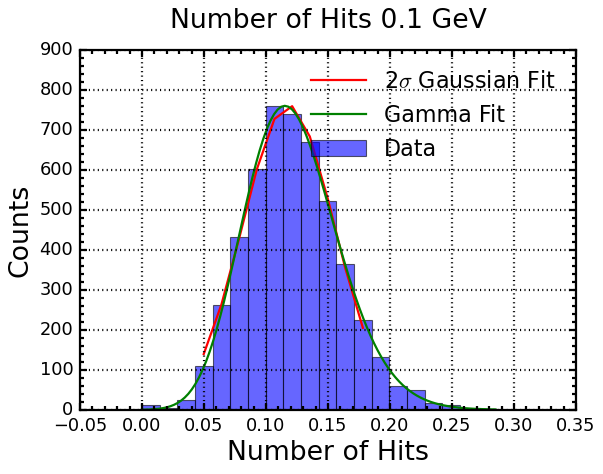

Mean: 0.28746752281716886, Peak: 0.2657971125661134, RMS: 0.057848036543939635
Initial Gamma Fit Parameters: [np.float64(68.18730468953524), np.float64(4.736788362616478), np.float64(0.01345361651562288), np.float64(0.057848036543939635)]
Gamma Fit Parameters: [ 6.81586996e+01  4.73678836e+01 -1.02807818e-01  8.26733134e-03]
Gamma Fit Peak: 0.28879817099975835 ± 0.0011773661312919708, Resolution: 0.1970211708511643 ± 0.0030133520161000483
Initial Gaussian Fit Parameters: [4.93000000e+02 1.97021171e-01 2.80530840e-01]
Gaussian Fit Peak: 0.2843604683275908 ± 0.001148762046043065, Resolution: 0.19745140203542288 ± 0.004383338098693814
Initial Log Normal Fit Parameters: [4.9300000e+02 1.9923957e-01 1.0000000e-01 2.8181806e-01]
Log Normal Fit Parameters: [6.82924080e+01 1.99733353e-01 7.43620261e-16 2.87554234e-01]
Log Normal Fit Peak: 0.27630852099318315 ± 0.001699826672007245, Resolution: 0.2017420201251821 ± 0.0067493950312232645


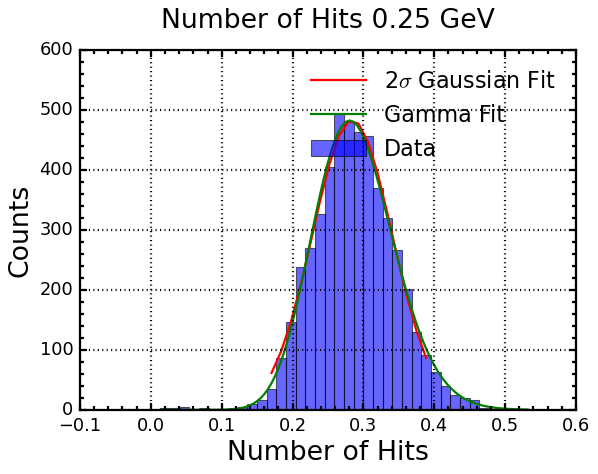

Mean: 0.5628499625583099, Peak: 0.49778259251816614, RMS: 0.0814178527336328
Initial Gamma Fit Parameters: [np.float64(77.3932922179753), np.float64(5.08187820015006), np.float64(0.14909435164823337), np.float64(0.0814178527336328)]
Gamma Fit Parameters: [ 7.77085964e+01  5.08187671e+01 -2.11764657e-02  1.15227019e-02]
Gamma Fit Peak: 0.564393038478964 ± 0.007245684398373389, Resolution: 0.14554079417711846 ± 0.009164646891304735
Initial Gaussian Fit Parameters: [5.03000000e+02 1.45540794e-01 5.52870337e-01]
Gaussian Fit Peak: 0.5580653528773184 ± 0.007685793850936196, Resolution: 0.14475161573788317 ± 0.015341981771107157
Initial Log Normal Fit Parameters: [5.03000000e+02 1.43904615e-01 1.00000000e-01 5.57052131e-01]
Log Normal Fit Parameters: [7.78134240e+01 1.46473353e-01 7.30417701e-13 5.61497081e-01]
Log Normal Fit Peak: 0.5495787810235232 ± 0.007171891736079063, Resolution: 0.14726250200241708 ± 0.012637124867125087


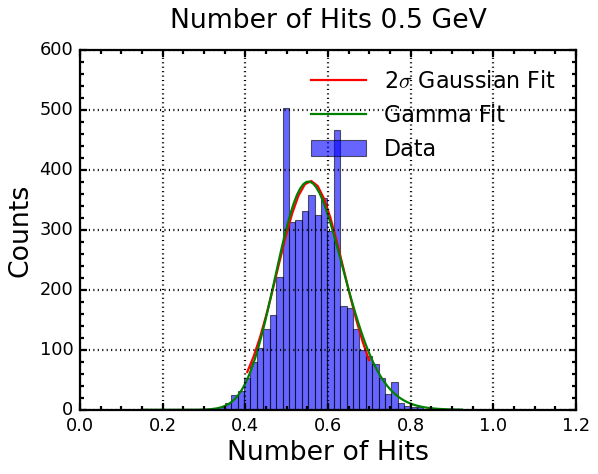

Mean: 1.0660080651470012, Peak: 1.0281414012190886, RMS: 0.12466035278566868
Initial Gamma Fit Parameters: [np.float64(106.88241993061217), np.float64(4.5066461180824815), np.float64(0.5042079701866747), np.float64(0.12466035278566868)]
Gamma Fit Parameters: [1.06736897e+02 2.55769560e+01 4.41420234e-01 2.45800848e-02]
Gamma Fit Peak: 1.07010398139506 ± 0.013903710933643808, Resolution: 0.11616674631834327 ± 0.00966427087293089
Initial Gaussian Fit Parameters: [4.78000000e+02 1.16166746e-01 1.04552390e+00]
Gaussian Fit Peak: 1.0567003960508825 ± 0.013532469655873994, Resolution: 0.11508750180651925 ± 0.013894981018643546
Initial Log Normal Fit Parameters: [4.78000000e+02 1.16544419e-01 1.00000000e-01 1.05879301e+00]
Log Normal Fit Parameters: [106.89250385   0.13361266   0.13843796   0.92347059]
Log Normal Fit Peak: 1.0455687251829044 ± 0.013664745216680995, Resolution: 0.11684984722625676 ± 0.010947850428215045


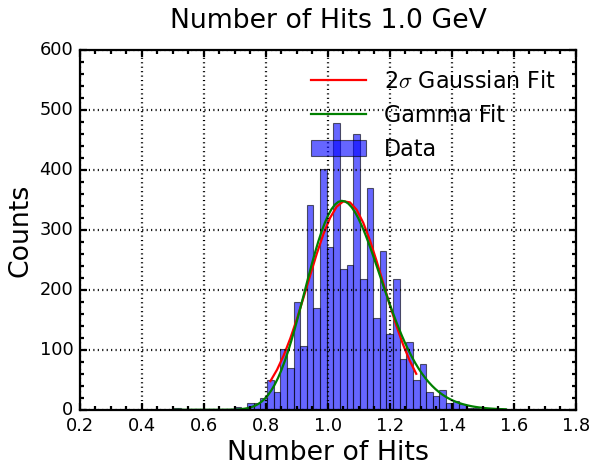

Mean: 2.0571266132258392, Peak: 2.057949781109855, RMS: 0.19431137777569457
Initial Gamma Fit Parameters: [np.float64(141.6985072808335), np.float64(3.4259086468014033), np.float64(1.3914335839321932), np.float64(0.19431137777569457)]
Gamma Fit Parameters: [1.40902537e+02 3.42590865e+01 9.40333774e-01 3.28160383e-02]
Gamma Fit Peak: 2.064581267868971 ± 0.017148006284498432, Resolution: 0.09303407770667417 ± 0.005939654931458452
Initial Gaussian Fit Parameters: [3.55000000e+02 9.30340777e-02 2.03176523e+00]
Gaussian Fit Peak: 2.0470384289534636 ± 0.015115335682062702, Resolution: 0.09222854762728065 ± 0.007988371010311962
Initial Log Normal Fit Parameters: [3.55000000e+02 9.42479841e-02 1.00000000e-01 2.04801047e+00]
Log Normal Fit Parameters: [1.40869829e+02 9.26754636e-02 7.00505766e-10 2.05248451e+00]
Log Normal Fit Peak: 2.0349317330380363 ± 0.01687734605464414, Resolution: 0.09287481144441065 ± 0.0060007693832288996


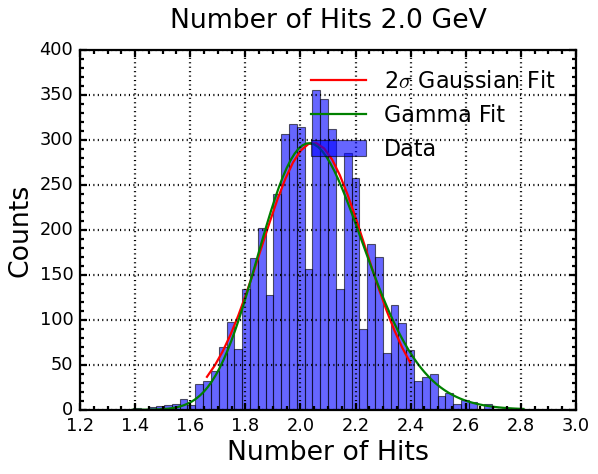

Mean: 5.1292172296672165, Peak: 4.874195761623269, RMS: 0.38177424011769157
Initial Gamma Fit Parameters: [np.float64(299.54564780287245), np.float64(4.5141403101325075), np.float64(3.405834742981738), np.float64(0.38177424011769157)]
Gamma Fit Parameters: [2.97790333e+02 4.51414031e+01 2.63619163e+00 5.55852106e-02]
Gamma Fit Peak: 5.145386028706562 ± 0.014095385473273265, Resolution: 0.07258198141080142 ± 0.0018994251337416674
Initial Gaussian Fit Parameters: [3.41000000e+02 7.25819814e-02 5.08980082e+00]
Gaussian Fit Peak: 5.1141500765178565 ± 0.013501081579824034, Resolution: 0.0716005653062205 ± 0.0028946997976691626
Initial Log Normal Fit Parameters: [3.41000000e+02 7.43285076e-02 1.00000000e-01 5.11506802e+00]
Log Normal Fit Parameters: [2.97939484e+02 8.62932789e-02 8.21664776e-01 4.30390164e+00]
Log Normal Fit Peak: 5.093636318948345 ± 0.013934351538880995, Resolution: 0.0726382298888374 ± 0.0020465493843235287


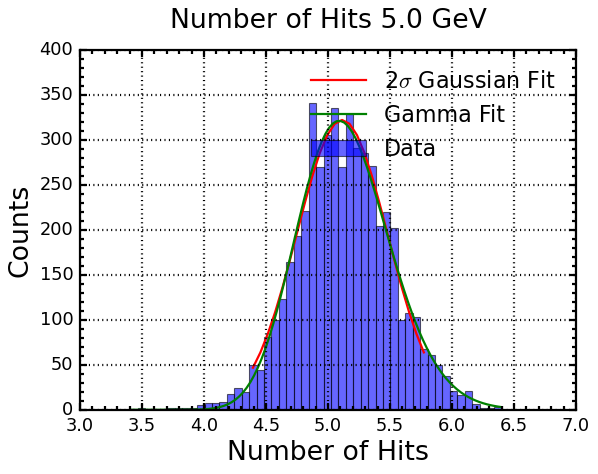

Mean: 10.248268066677303, Peak: 10.137605694679568, RMS: 0.6855543466622355
Initial Gamma Fit Parameters: [np.float64(624.6563902369576), np.float64(5.181890808963217), np.float64(6.695800298663482), np.float64(0.6855543466622355)]
Gamma Fit Parameters: [6.18603102e+02 5.18189081e+01 5.60119902e+00 9.07764199e-02]
Gamma Fit Peak: 10.305133983837637 ± 0.019575926494159394, Resolution: 0.06341084446401758 ± 0.0013012077852543576
Initial Gaussian Fit Parameters: [4.33000000e+02 6.34108445e-02 1.02143576e+01]
Gaussian Fit Peak: 10.258527622760848 ± 0.0192720703539012, Resolution: 0.06325927159053268 ± 0.002077550741073196
Initial Log Normal Fit Parameters: [4.33000000e+02 6.68199982e-02 1.00000000e-01 1.02254148e+01]
Log Normal Fit Parameters: [6.18401506e+02 6.31434849e-02 5.30948826e-17 1.02696394e+01]
Log Normal Fit Peak: 10.228774820744881 ± 0.0185228501159777, Resolution: 0.06320647709183654 ± 0.0012423987423490156


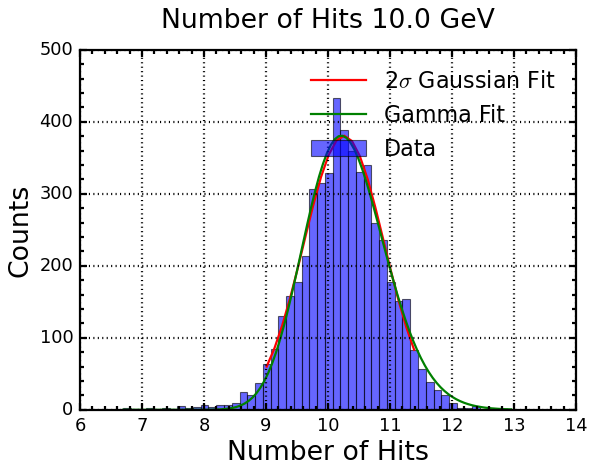

Mean: 20.538730359918073, Peak: 20.545819691906757, RMS: 1.3148664711792284
Initial Gamma Fit Parameters: [np.float64(1144.8888614005982), np.float64(5.319884677968968), np.float64(13.54379236631657), np.float64(1.3148664711792284)]
Gamma Fit Parameters: [1.11966103e+03 5.31988468e+01 1.22727872e+01 1.59574606e-01]
Gamma Fit Peak: 20.761972195874854 ± 0.046410157275303905, Resolution: 0.05605912096376881 ± 0.001523883883521772
Initial Gaussian Fit Parameters: [4.28000000e+02 5.60591210e-02 2.06023976e+01]
Gaussian Fit Peak: 20.689910770806485 ± 0.03820112281354488, Resolution: 0.05557327615000572 ± 0.0020082001665350673
Initial Log Normal Fit Parameters: [4.28000000e+02 6.39534291e-02 1.32709970e-01 2.04967712e+01]
Log Normal Fit Parameters: [1.11897408e+03 5.56957145e-02 1.25901276e-13 2.06984439e+01]
Log Normal Fit Peak: 20.634336565238087 ± 0.042615504053342, Resolution: 0.0557389346505363 ± 0.0013886949363632142


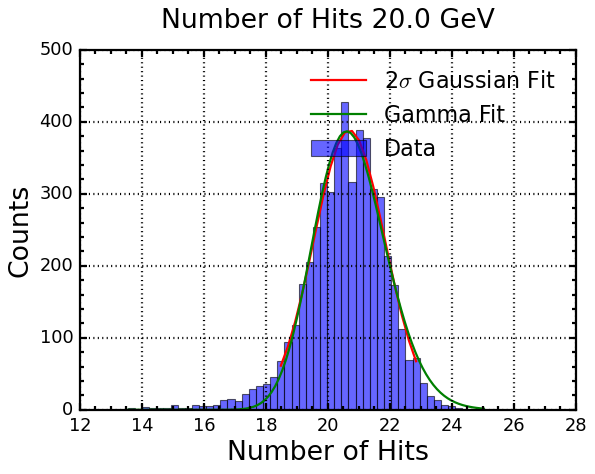

Mean: 30.77284559765072, Peak: 31.510579244313195, RMS: 2.1397207924038106
Initial Gamma Fit Parameters: [np.float64(1822.1157133110596), np.float64(5.730507069657984), np.float64(18.5111604696865), np.float64(2.1397207924038106)]
Gamma Fit Parameters: [1.74245898e+03 5.73050707e+01 1.88992747e+01 2.16070684e-01]
Gamma Fit Peak: 31.281220481473554 ± 0.07095853457653921, Resolution: 0.05228880095016317 ± 0.001537083640972474
Initial Gaussian Fit Parameters: [4.46000000e+02 5.22888010e-02 3.10651498e+01]
Gaussian Fit Peak: 31.18482168850076 ± 0.05319933946773971, Resolution: 0.05196105224522811 ± 0.0018417140996285623
Initial Log Normal Fit Parameters: [4.46000000e+02 6.94489320e-02 9.59563506e-01 3.06987239e+01]
Log Normal Fit Parameters: [1.74026596e+03 5.18381002e-02 2.21745331e-11 3.11938513e+01]
Log Normal Fit Peak: 31.11014007121606 ± 0.06353381212815415, Resolution: 0.05187294442254526 ± 0.0013395766007207866


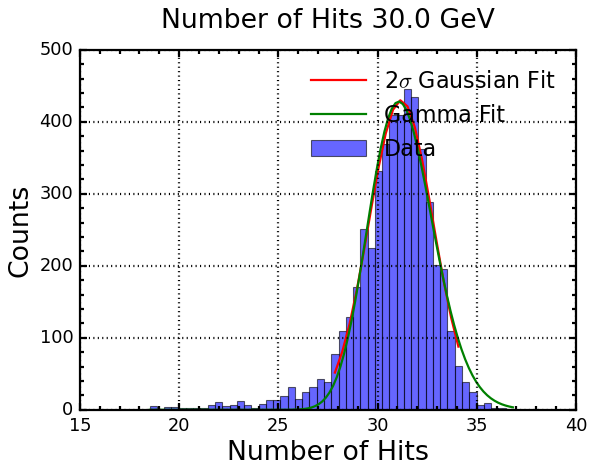

Mean: 40.794813399024235, Peak: 41.66847209331273, RMS: 2.890150662867885
Initial Gamma Fit Parameters: [np.float64(2213.685354232325), np.float64(5.468817506856007), np.float64(24.989106856480852), np.float64(2.890150662867885)]
Gamma Fit Parameters: [2.06500515e+03 4.96585317e+01 2.72835304e+01 2.89015066e-01]
Gamma Fit Peak: 41.635594187487925 ± 0.10399134321829832, Resolution: 0.04891619336467542 ± 0.0016988231469669097
Initial Gaussian Fit Parameters: [4.17000000e+02 4.89161934e-02 4.13465791e+01]
Gaussian Fit Peak: 41.51766091054993 ± 0.0586522729865746, Resolution: 0.04690724745311867 ± 0.0015162871957045197
Initial Log Normal Fit Parameters: [4.17000000e+02 7.07573762e-02 1.17887653e+00 4.06928193e+01]
Log Normal Fit Parameters: [2.05702731e+03 4.81569666e-02 3.63412581e-09 4.15096288e+01]
Log Normal Fit Peak: 41.41347563048774 ± 0.09138931487718631, Resolution: 0.048184900178852214 ± 0.001449683907834912


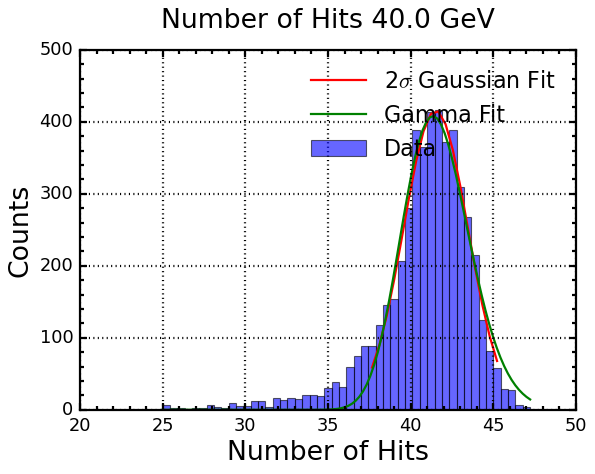

Mean: 50.454090694913866, Peak: 52.43463604178257, RMS: 3.6758993931721045
Initial Gamma Fit Parameters: [np.float64(2797.763545174514), np.float64(5.505406267403027), np.float64(30.216771137401178), np.float64(3.6758993931721045)]
Gamma Fit Parameters: [2.57551519e+03 4.38293807e+01 3.55664880e+01 3.67589939e-01]
Gamma Fit Peak: 51.67772739307307 ± 0.15980825417515546, Resolution: 0.04709153827485479 ± 0.002119146209022414
Initial Gaussian Fit Parameters: [4.84000000e+02 4.70915383e-02 5.13101375e+01]
Gaussian Fit Peak: 51.52171881641017 ± 0.11642195009064679, Resolution: 0.04491354752852864 ± 0.00242091725307732
Initial Log Normal Fit Parameters: [4.84000000e+02 7.27599162e-02 2.37961508e+00 5.03207152e+01]
Log Normal Fit Parameters: [2.55527498e+03 4.58397044e-02 7.02270765e-10 5.15182540e+01]
Log Normal Fit Peak: 51.4101134335848 ± 0.13923803218462485, Resolution: 0.045863795465354525 ± 0.0017470408625504964


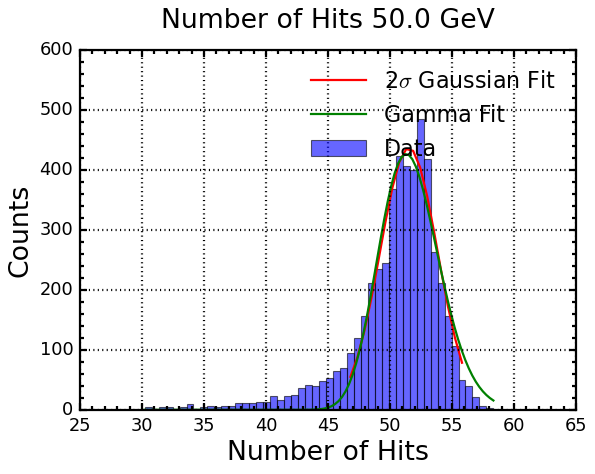

Mean: 59.339199284041214, Peak: 60.1844247176375, RMS: 4.492216729809279
Initial Gamma Fit Parameters: [np.float64(3297.581612138147), np.float64(5.640105953245962), np.float64(34.00262096297279), np.float64(4.492216729809279)]
Gamma Fit Parameters: [2.98817648e+03 3.39714663e+01 4.57677969e+01 4.49221673e-01]
Gamma Fit Peak: 61.02851581135828 ± 0.17634668043071652, Resolution: 0.042902740921476376 ± 0.0020136167926477753
Initial Gaussian Fit Parameters: [4.97000000e+02 4.29027409e-02 6.05792941e+01]
Gaussian Fit Peak: 60.835654635516036 ± 0.09686093491714744, Resolution: 0.041178214545683496 ± 0.0016910423663655198
Initial Log Normal Fit Parameters: [4.97000000e+02 7.55959021e-02 1.35171368e+00 5.91698872e+01]
Log Normal Fit Parameters: [2.97114470e+03 4.18026705e-02 6.30990400e-10 6.08175864e+01]
Log Normal Fit Peak: 60.7114027037741 ± 0.14422168790195647, Resolution: 0.04182093931469881 ± 0.0015783175813216328


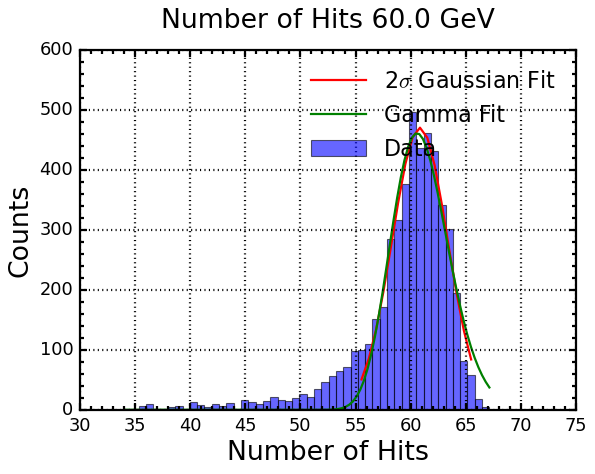

Saving N hits fit results to /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF3/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.75mm_layer40_in80/Reco_Results/NHits_Calib_Fit.csv


In [34]:
results = []
for i_E in range(len(Energy_test)):
    hist = hist_N_Calib[i_E]
    (mean_gauss, mean_gauss_error, peak_gauss, peak_gauss_error, res_gauss, res_gauss_error,
     mean_gamma, mean_gamma_error, peak_gamma, peak_gamma_error, res_gamma, res_gamma_error,
     mean_log_normal, mean_log_normal_error, peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error) = fit_all(hist['Energy'],"N", hist['bin_edges'], hist['counts'])

    results.append({
        "ParticleEnergy": Energy_test[i_E],
        "Mean_Gauss": mean_gauss,
        "Mean_Gauss_Error": mean_gauss_error,
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Mean_Gamma": mean_gamma,
        "Mean_Gamma_Error": mean_gamma_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Mean_LogNormal": mean_log_normal,
        "Mean_LogNormal_Error": mean_log_normal_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
if not os.path.exists(os.path.join(DataPath_Validate, "Reco_Results")):
    os.makedirs(os.path.join(DataPath_Validate, "Reco_Results"))
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/NHits_Calib_Fit_Threshold{Threshold_i}.csv")
outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/NHits_Calib_Fit.csv")
#outputfile_name = os.path.join(DataPath_Validate, f"Reco_Results/NHits_Fit.csv")
print(f"Saving N hits fit results to {outputfile_name}")
df.to_csv(outputfile_name, index=False)

